In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
import docx2txt
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('women_ecommerce.csv')

## Selecting the relevant columns

In [6]:
df = df[['Title', 'Review Text', 'Rating', 'Division Name', 'Department Name']]

In [8]:
df.head(10)

,Title,Review Text,Rating,Division Name,Department Name
0,NaN,Absolutely wonderful - silky and sexy and comf...,4,Initmates,Intimate
1,NaN,Love this dress! it's sooo pretty. i happene...,5,General,Dresses
2,Some major design flaws,I had such high hopes for this dress and reall...,3,General,Dresses
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,General Petite,Bottoms
4,Flattering shirt,This shirt is very flattering to all due to th...,5,General,Tops
5,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,General,Dresses
6,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,General Petite,Tops
7,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,General Petite,Tops
8,Flattering,I love this dress. i usually get an xs but it ...,5,General,Dresses
9,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,General,Dresses


## Standardizing header names

In [26]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')

## Exploring the data at hand and assessing data cleaning steps

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            19676 non-null  object
 1   review_text      22641 non-null  object
 2   rating           23486 non-null  int64 
 3   division_name    23472 non-null  object
 4   department_name  23472 non-null  object
dtypes: int64(1), object(4)
memory usage: 917.5+ KB


In [29]:
df.describe()

,rating
count,23486.000000
mean,4.196032
std,1.110031
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Some nulls have to be dropped, but only the ones in the subset of review text, department name and division name. If a review doesn't have a title, it's still valuable data.

## Grouping & plotting the data

In [79]:
aggregation = ['division_name', 'department_name']
df_by_dept = df.groupby(aggregation).agg('mean')

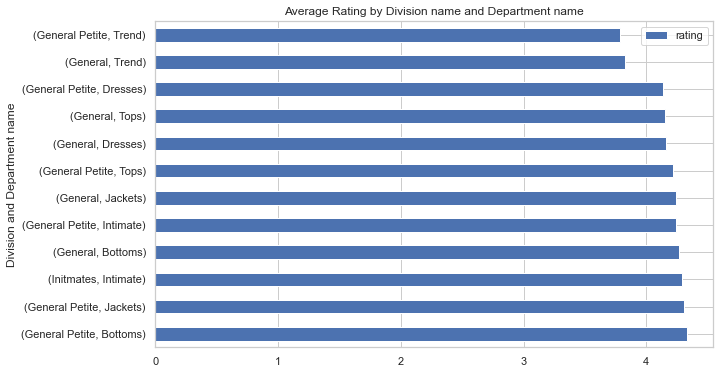

In [40]:
df_by_dept.sort_values('rating', ascending=False).plot(kind='barh', 
                                                       title='Average Rating by Division name and Department name', 
                                                       ylabel='Average rating', 
                                                       xlabel='Division and Department name', 
                                                       figsize=(10, 6));

## Sample checks for polarity and subjectivity + sentences

In [53]:
sample.iloc[0].review_text

"Just got this dress in an xl. i've never ordered from retailer before so i expected their clothes to run small. i was wrong. it's a beautiful high quality dress but i think it's just too big. i may end up exchanging it for a l. definitely size down in this dress!"

In [59]:
sample = df.sample(3)
for i in range(3):
    print(f'\n{TextBlob(sample.iloc[i].review_text).sentences}')
    print(f'\n{TextBlob(sample.iloc[i].review_text).sentiment}')


[Sentence("I tried this shirt on in store, and loved it!"), Sentence("it has a flattering fit and is very comfortable."), Sentence("i read some other reviews about the quality not being good, i don't feel that way at all."), Sentence("the knit and the silky/satiny materials both feel like quality to me."), Sentence("the one concern i have is that it may wrinkle easily."), Sentence("i'm 5'4'' and 125lbs and the xs fits well."), Sentence("i plan to pair it with skinny jeans.")]

Sentiment(polarity=0.46722222222222226, subjectivity=0.6680555555555556)

[Sentence("This is a nice, easy, go to shirt that i will be grabbing for this fall."), Sentence("comfy, but still styled to add a little fun in the everyday white tee.")]

Sentiment(polarity=0.15763888888888888, subjectivity=0.5222222222222223)

[Sentence("I bought this dress for a fall wedding and upon receiving it was very impressed with the quality of lace and the color."), Sentence("however upon trying it on the seam up the back was sl

## Dropping nulls in the review text

In [61]:
df.dropna(subset=['review_text'], inplace=True)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            19675 non-null  object
 1   review_text      22641 non-null  object
 2   rating           22641 non-null  int64 
 3   division_name    22628 non-null  object
 4   department_name  22628 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


## Sentiment analysis for each row

In [65]:
df['sentiment_score'] = df['review_text'].apply(lambda x:TextBlob(x).sentiment.polarity)
df['subjectivity_score'] = df['review_text'].apply(lambda x:TextBlob(x).sentiment.subjectivity)

## Min review polarity by division and department

In [80]:
min_polarity = df.groupby(aggregation).agg({'sentiment_score': 'min'}).sort_values('sentiment_score')
min_polarity

sentiment_score
division_name  department_name                 
General        Tops                   -0.975000
               Dresses                -0.916667
               Jackets                -0.750000
General Petite Tops                   -0.700000
               Intimate               -0.575000
               Jackets                -0.562500
General        Bottoms                -0.533333
General Petite Dresses                -0.400000
Initmates      Intimate               -0.392333
General        Trend                  -0.270833
General Petite Bottoms                -0.257778
               Trend                  -0.083333

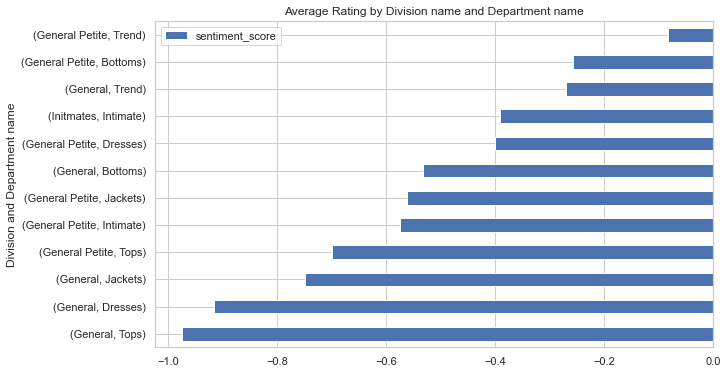

In [74]:
min_polarity.plot(kind='barh',
                  title='Average Rating by Division name and Department name',
                  ylabel='Average rating', 
                  xlabel='Division and Department name', 
                  figsize=(10, 6));

## Average review polarity by division and department

In [77]:
avg_polarity = df.groupby(aggregation).agg({'sentiment_score': 'mean'}).sort_values('sentiment_score')
avg_polarity

sentiment_score
division_name  department_name                 
General Petite Trend                   0.195925
General        Trend                   0.203986
               Jackets                 0.237141
General Petite Intimate                0.239517
               Jackets                 0.241773
General        Bottoms                 0.245849
               Tops                    0.247025
General Petite Dresses                 0.248380
General        Dresses                 0.251091
General Petite Tops                    0.256835
Initmates      Intimate                0.256979
General Petite Bottoms                 0.259258

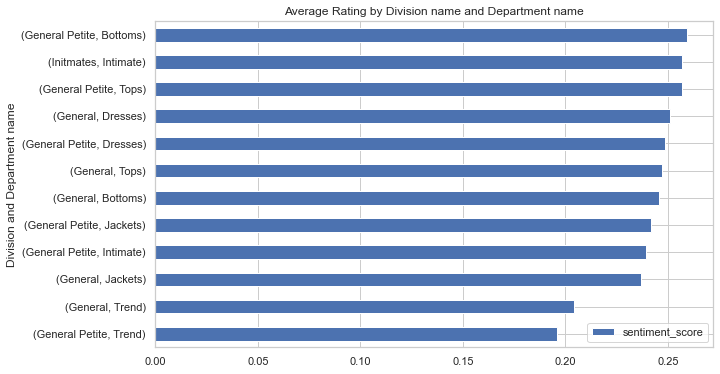

In [76]:
avg_polarity.plot(kind='barh',
                  title='Average Rating by Division name and Department name',
                  ylabel='Average rating', 
                  xlabel='Division and Department name', 
                  figsize=(10, 6));